In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pydub
!apt-get install -y python3-pyaudio
!pip install SpeechRecognition

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libportaudio2
Suggested packages:
  python-pyaudio-doc
The following NEW packages will be installed:
  libportaudio2 python3-pyaudio
0 upgraded, 2 newly installed, 0 to remove and 16 not upgraded.
Need to get 91.2 kB of archives.
After this operation, 340 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 python3-pyaudio amd64 0.2.11-1.3ubuntu1 [25.9 kB]
Fetched 91.2 kB in 1s (141 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 120831 files and directories currently installed.)
Preparing to unpack .../libportaudio2_19.6.0-1.1_amd64.deb ...
Unpacking libportaudio2:amd64 (19.6.0-1.1) ...
Selecting previously unselected package python3-pyaudio.
Prepa

In [ ]:
!pip install pytube
import os
import math
import speech_recognition as sr
from pydub import AudioSegment
from pytube import YouTube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 919.3 kB/s eta 0:00:00


In [ ]:
!pip install librosa scikit-learn


In [ ]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split

# Specify the paths to your speech and non-speech directories
speech_dir = "/content/drive/MyDrive/newdata5000"
non_speech_dir = "/content/drive/MyDrive/data_preprocessed"

def extract_features(audio_path):
    y, sr = librosa.load(audio_path)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    return mfcc.mean(axis=1)  # Use the mean of MFCC coefficients as features

# Get the list of speech audio file names
list_of_speech_files = [f for f in os.listdir(speech_dir) if f.endswith(".wav")]

# Get the list of non-speech audio file names
list_of_non_speech_files = [f for f in os.listdir(non_speech_dir) if f.endswith(".wav")]

# Load and preprocess data
speech_files = [os.path.join(speech_dir, filename) for filename in list_of_speech_files]
non_speech_files = [os.path.join(non_speech_dir, filename) for filename in list_of_non_speech_files]

speech_features = np.array([extract_features(file) for file in speech_files])
non_speech_features = np.array([extract_features(file) for file in non_speech_files])

# Create labels: 1 for speech, 0 for non-speech
speech_labels = np.ones(len(speech_features))
non_speech_labels = np.zeros(len(non_speech_features))

# Concatenate and shuffle data
X = np.concatenate((speech_features, non_speech_features), axis=0)
y = np.concatenate((speech_labels, non_speech_labels), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train a Random Forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 1.00


In [ ]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities for the positive class (speech)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Find threshold corresponding to a desired precision level
desired_precision = 0.90
idx = np.argmax(precision >= desired_precision)

ideal_threshold = thresholds[idx]
print(f"Ideal Threshold: {ideal_threshold:.4f}")


Ideal Threshold: 0.0400


In [ ]:
import librosa
import numpy as np

# Load the audio file
audio_file = "/content/drive/MyDrive/hi/signofthecross_10_gaume_64kb.mp3"
y, sr = librosa.load(audio_file)
# print(sr)
# Calculate the energy of the audio signal
energy = np.square(y)

# Set parameters
min_speech_length = 300 #seconds
min_spike_interval = 2  #seconds
min_continuous_gap = 60  #seconds between two different segments
spike_threshold = 0.04  # Adjust this threshold based on your audio characteristics

# Detect spike segments
spike_segments = []
current_segment = None

for i, e in enumerate(energy):
    if e > spike_threshold:
        if current_segment is None:
            current_segment = i
    elif current_segment is not None:
        if (i - current_segment) >= (min_spike_interval * sr):
            spike_segments.append((current_segment, i))
            current_segment = None

# Combine close consecutive segments
final_segments = []
for start, end in spike_segments:
    if final_segments and (start - final_segments[-1][1]) < (min_continuous_gap * sr):
        final_segments[-1] = (final_segments[-1][0], end)
    else:
        final_segments.append((start, end))

# Print identified speech segments in hours, minutes, and seconds format
for idx, (start, end) in enumerate(final_segments):
    start_time = librosa.samples_to_time(start, sr=sr)
    end_time = librosa.samples_to_time(end, sr=sr)

    # Calculate the duration of the speech segment in seconds
    segment_duration = end_time - start_time

    # Skip segments that are less than 5 minutes in duration
    if segment_duration < 5 * 60:
        continue

    # Convert start and end times to hours, minutes, and seconds format
    start_hms = int(start_time // 3600)
    start_mms = int((start_time % 3600) // 60)
    start_secs = int(start_time % 60)

    end_hms = int(end_time // 3600)
    end_mms = int((end_time % 3600) // 60)
    end_secs = int(end_time % 60)

    print(f"Speech Segment {idx + 1}: Start - {start_hms:02d}:{start_mms:02d}:{start_secs:02d}, "
          f"End - {end_hms:02d}:{end_mms:02d}:{end_secs:02d}")



Speech Segment 1: Start - 00:00:02, End - 00:22:33


In [ ]:
import librosa
import numpy as np
import os
from scipy.io.wavfile import write

# Load the audio file
audio_file = "/content/drive/MyDrive/send Google.mp3"
y, sr = librosa.load(audio_file)

# Calculate the energy of the audio signal
energy = np.square(y)

# Set parameters
min_speech_length = 300  # seconds
min_spike_interval = 2   # seconds
min_continuous_gap = 60  # seconds between two different segments
spike_threshold = 0.04   # Adjust this threshold based on your audio characteristics

# Detect spike segments
spike_segments = []
current_segment = None

for i, e in enumerate(energy):
    if e > spike_threshold:
        if current_segment is None:
            current_segment = i
    elif current_segment is not None:
        if (i - current_segment) >= (min_spike_interval * sr):
            spike_segments.append((current_segment, i))
            current_segment = None

# Combine close consecutive segments
final_segments = []
for start, end in spike_segments:
    if final_segments and (start - final_segments[-1][1]) < (min_continuous_gap * sr):
        final_segments[-1] = (final_segments[-1][0], end)
    else:
        final_segments.append((start, end))

# Output directory to save speech segments (Adjust this path)
output_directory = "/content/drive/MyDrive/speech_segments_wav/"
os.makedirs(output_directory, exist_ok=True)

# Save detected speech segments as separate WAV files
for idx, (start, end) in enumerate(final_segments):
    segment_audio = y[start:end]
    segment_duration = end - start

    # Skip segments that are less than 5 minutes in duration
    if segment_duration < 5 * sr:
        continue

    segment_filename = f"speech_segment_{idx + 1}.wav"
    segment_filepath = os.path.join(output_directory, segment_filename)

    # Save the segment as a WAV file using scipy
    write(segment_filepath, sr, segment_audio)

    # Calculate the start and end times in hours, minutes, and seconds
    start_time = librosa.samples_to_time(start, sr=sr)
    end_time = librosa.samples_to_time(end, sr=sr)

    # Convert start and end times to hour::minute::second format
    start_hms = '{:02d}:{:02d}:{:02d}'.format(int(start_time // 3600), int((start_time % 3600) // 60), int(start_time % 60))
    end_hms = '{:02d}:{:02d}:{:02d}'.format(int(end_time // 3600), int((end_time % 3600) // 60), int(end_time % 60))

    print(f"Saved Speech Segment {idx + 1} to {segment_filepath}: "
          f"Start - {start_hms}, End - {end_hms}")


Saved Speech Segment 1 to /content/drive/MyDrive/speech_segments_wav/speech_segment_1.wav: Start - 00:00:12, End - 00:08:48
Saved Speech Segment 2 to /content/drive/MyDrive/speech_segments_wav/speech_segment_2.wav: Start - 00:14:22, End - 00:19:32
Saved Speech Segment 3 to /content/drive/MyDrive/speech_segments_wav/speech_segment_3.wav: Start - 00:22:19, End - 00:34:30
Saved Speech Segment 4 to /content/drive/MyDrive/speech_segments_wav/speech_segment_4.wav: Start - 00:36:18, End - 00:37:30
Saved Speech Segment 5 to /content/drive/MyDrive/speech_segments_wav/speech_segment_5.wav: Start - 00:39:38, End - 00:52:40
Saved Speech Segment 6 to /content/drive/MyDrive/speech_segments_wav/speech_segment_6.wav: Start - 00:53:40, End - 00:54:19


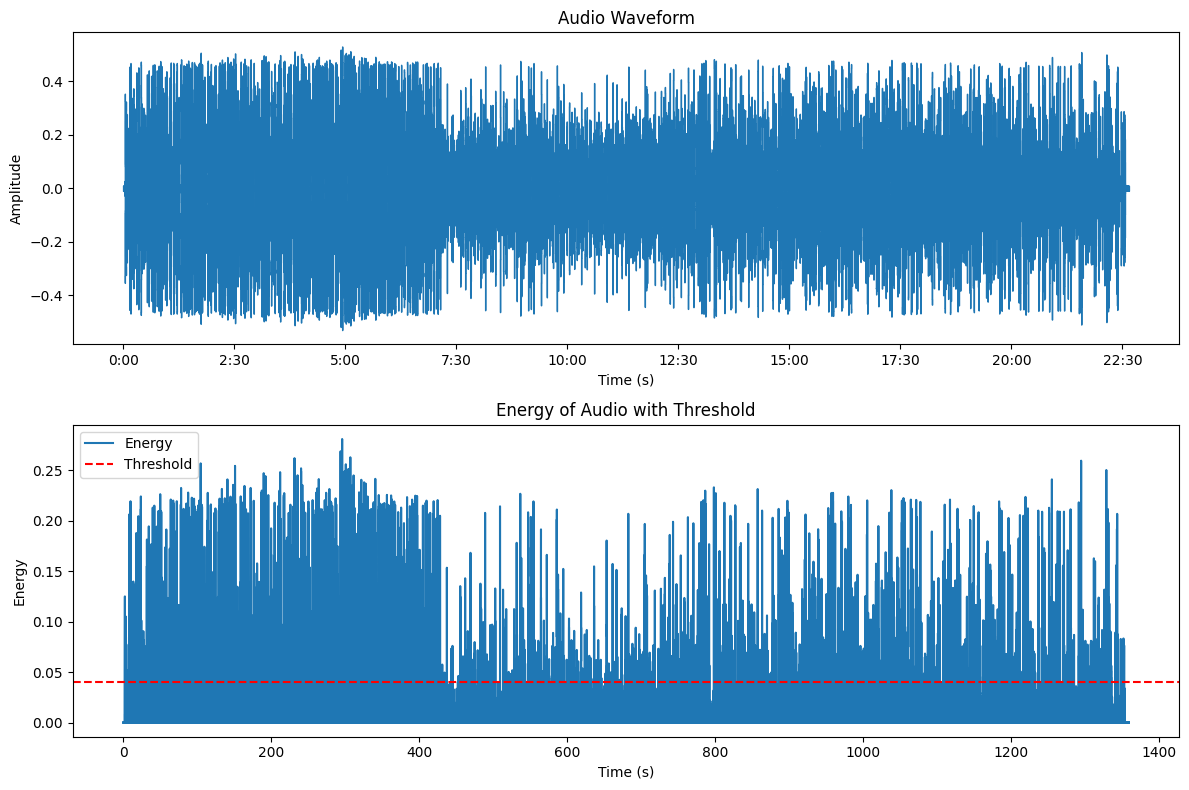

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

# Load the audio file
audio_file = "/content/drive/MyDrive/hi/signofthecross_10_gaume_64kb.mp3"
y, sr = librosa.load(audio_file)

# Calculate the energy of the audio signal
energy = np.square(y)

# Set the threshold value
spike_threshold = 0.04

# Plot the audio waveform
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title("Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Plot the energy graph along with the threshold
plt.subplot(2, 1, 2)
plt.plot(np.linspace(0, len(energy) / sr, len(energy)), energy, label='Energy')
plt.axhline(y=spike_threshold, color='r', linestyle='--', label='Threshold')
plt.title("Energy of Audio with Threshold")
plt.xlabel("Time (s)")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()

plt.show()


In [1]:
import shutil

# Replace 'source_file_path' and 'destination_directory' with the appropriate paths
source_file_path = '/content/drive/MyDrive/Colab Notebooks/Solution2.ipynb'
destination_directory = 'https://github.com/Vsquarekgp/Speaker_Noise_Segmentation'

shutil.copy(source_file_path, destination_directory)


FileNotFoundError: ignored